# Graph Features + MLP Baseline

**Objective**: Node features + graph structural features (degree centrality) with MLP.

**Key principle**: Each node v evaluated at exactly t_first(v) + K.

In [1]:
import sys
from pathlib import Path

ROOT = Path.cwd().parent.parent
sys.path.insert(0, str(ROOT))

from code_lib.temporal_node_classification_builder import (
    TemporalNodeClassificationBuilder,
    load_elliptic_data,
    prepare_observation_window_graphs
)

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch_geometric.utils import degree
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from tqdm.notebook import tqdm

torch.manual_seed(42)
np.random.seed(42)

## Configuration

In [2]:
from test_config import EXPERIMENT_CONFIG

CONFIG = EXPERIMENT_CONFIG
print(f"Device: {CONFIG['device']}")

Device: cuda


In [3]:
def remove_correlated_features(nodes_df, threshold=0.95, verbose=True):
    """
    Remove highly correlated features from nodes DataFrame.
    """
    exclude_cols = {'address', 'Time step', 'class'}
    feature_cols = [col for col in nodes_df.columns
                    if col not in exclude_cols and
                    pd.api.types.is_numeric_dtype(nodes_df[col])]

    sample_size = min(10000, len(nodes_df))
    sample_df = nodes_df[feature_cols].sample(n=sample_size, random_state=42)
    corr_matrix = sample_df.corr().abs()

    to_remove = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > threshold:
                to_remove.add(corr_matrix.columns[j])

    features_to_keep = [col for col in feature_cols if col not in to_remove]

    if verbose:
        print(f"Original features: {len(feature_cols)}")
        print(f"Removed features:  {len(to_remove)}")
        print(f"Kept features:     {len(features_to_keep)}")

    return features_to_keep

## Load Data & Create Splits

In [4]:
nodes_df, edges_df = load_elliptic_data(CONFIG['data_dir'], use_temporal_features=True)

Loading trmporal features...
Loading node classes...
Loading edges...


In [7]:
kept_features = remove_correlated_features(nodes_df, threshold=0.95, verbose=False)

In [6]:
builder = TemporalNodeClassificationBuilder(
    nodes_df=nodes_df,
    edges_df=edges_df,
    feature_cols=kept_features,
    include_class_as_feature=False,
    add_temporal_features=True,
    cache_dir='../../graph_cache_reduced_features_fixed',
    use_cache=True,
    verbose=True
)

split = builder.get_train_val_test_split(
    train_timesteps=CONFIG['train_timesteps'],
    val_timesteps=CONFIG['val_timesteps'],
    test_timesteps=CONFIG['test_timesteps'],
    filter_unknown=True
)

print(f"\nTrain: {len(split['train'])} nodes")
print(f"Val:   {len(split['val'])} nodes")
print(f"Test:  {len(split['test'])} nodes")

  Pre-processing node features by (address, timestep)...
  Pre-processing edges by timestep...
  Average new nodes per timestep: 16794.7
Initialized TemporalNodeClassificationBuilder
  Total nodes: 822942
  Total edges: 2868964
  Time steps: 1 to 49
  Feature columns (36): ['in_num', 'in_total_fees', 'in_mean_fees', 'in_total_btc_in', 'in_mean_btc_in']...
  Include class as feature: False
  Add temporal features: True
  Add edge weights: False

Temporal Split Summary:
  Train: timesteps 5-26, 104704 nodes
    Illicit: 6698, Licit: 98006
Training illicit ratio: 0.06397081295843521
  Val:   timesteps 27-31, 11230 nodes
    Illicit: 809, Licit: 10421
Validation illicit ratio: 0.07203918076580587
  Test:  timesteps 32-40, 45963 nodes
    Illicit: 3682, Licit: 42281
Test illicit ratio: 0.08010791288645215

Train: 104704 nodes
Val:   11230 nodes
Test:  45963 nodes


## Prepare Per-Node Graphs

Each node evaluated at t_first(v) + K.

In [8]:
device = torch.device(CONFIG['device'])

graphs = prepare_observation_window_graphs(
    builder,
    split['train'],
    split['val'],
    split['test'],
    K_values=CONFIG['observation_windows'],
    device=device
)


PREPARING OBSERVATION WINDOW GRAPHS (PER-NODE EVALUATION)

K = 1 (Each node evaluated at t_first + 1)

TRAIN split:
  Nodes to evaluate: 104,704
  Evaluation times: t=6 to t=27
  Unique graphs needed: 22
  ✅ Loaded cached graph from ../../graph_cache_reduced_features_fixed/graph_t6_metaTrue_classFalse_tempTrue_weightsFalse.pt
  ✅ Loaded cached graph from ../../graph_cache_reduced_features_fixed/graph_t7_metaTrue_classFalse_tempTrue_weightsFalse.pt
  ✅ Loaded cached graph from ../../graph_cache_reduced_features_fixed/graph_t8_metaTrue_classFalse_tempTrue_weightsFalse.pt
  ✅ Loaded cached graph from ../../graph_cache_reduced_features_fixed/graph_t9_metaTrue_classFalse_tempTrue_weightsFalse.pt
  ✅ Loaded cached graph from ../../graph_cache_reduced_features_fixed/graph_t10_metaTrue_classFalse_tempTrue_weightsFalse.pt
  ✅ Loaded cached graph from ../../graph_cache_reduced_features_fixed/graph_t11_metaTrue_classFalse_tempTrue_weightsFalse.pt
  ✅ Loaded cached graph from ../../graph_cache_re

## Augment with Graph Structural Features

Add degree centrality (in/out/total) to node features.

In [9]:
def compute_graph_features(data):
    """Add comprehensive graph structural features."""
    from torch_geometric.utils import degree
    import torch

    device = data.x.device
    num_nodes = data.num_nodes
    edge_index = data.edge_index.to(device)

    # 1-3. Degree centrality
    deg_total = degree(edge_index[0], num_nodes=num_nodes, dtype=torch.float).to(device)
    deg_in    = degree(edge_index[1], num_nodes=num_nodes, dtype=torch.float).to(device)
    deg_out   = degree(edge_index[0], num_nodes=num_nodes, dtype=torch.float).to(device)

    # 4. PageRank approximation (simple power iteration, vectorized)
    pr = torch.ones(num_nodes, device=device) / num_nodes
    deg_out_safe = deg_out.clone()
    deg_out_safe[deg_out_safe == 0] = 1

    src, dst = edge_index  # both on `device`
    for _ in range(5):  # 5 iterations
        pr_new = torch.zeros(num_nodes, device=device)
        pr_new.index_add_(0, dst, pr[src] / deg_out_safe[src])
        pr = 0.85 * pr_new + 0.15 / num_nodes
    pagerank = pr

    # 5. Betweenness approximation
    betweenness_approx = (deg_in * deg_out) / (deg_total + 1e-8)

    # 6. Degree ratio
    degree_ratio = deg_in / (deg_out + 1e-8)

    # 7. Normalized degree
    deg_normalized = deg_total / (deg_total.max() + 1e-8)

    # Stack all 7 features (all already on `device`)
    graph_feats = torch.stack([
        deg_total, deg_in, deg_out,
        pagerank, betweenness_approx,
        degree_ratio, deg_normalized
    ], dim=1)

    combined_feats = torch.cat([data.x, graph_feats], dim=1)
    return combined_feats



# Augment all graphs with centrality features
print("Adding graph structural features...")
for K in CONFIG['observation_windows']:
    for split_name in ['train', 'val', 'test']:
        for eval_t, graph in graphs[K][split_name]['graphs'].items():
            graph.x = compute_graph_features(graph)
    first_graph = list(graphs[K]['train']['graphs'].values())[0]
    print(f"  K={K}: {first_graph.x.shape[1]} total features")

Adding graph structural features...
  K=1: 44 total features
  K=3: 44 total features
  K=5: 44 total features
  K=7: 44 total features


## MLP Model

In [10]:
class MLP(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout=0.3):
        super().__init__()
        self.fc1 = nn.Linear(num_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, num_classes)
        self.dropout = dropout
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.fc3(x)
        return x

## Training Functions

In [11]:
def train_epoch(model, graphs_dict, optimizer, criterion):
    """Train on all graphs in split."""
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for eval_t, graph in graphs_dict.items():
        optimizer.zero_grad()
        logits = model(graph.x)
        
        # Loss only on masked nodes
        loss = criterion(logits[graph.eval_mask], graph.y[graph.eval_mask])
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * graph.eval_mask.sum().item()
        pred = logits[graph.eval_mask].argmax(dim=1)
        total_correct += (pred == graph.y[graph.eval_mask]).sum().item()
        total_samples += graph.eval_mask.sum().item()
    
    return total_loss / total_samples, total_correct / total_samples


def evaluate(model, graphs_dict):
    """Evaluate on all graphs in split."""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for eval_t, graph in graphs_dict.items():
            logits = model(graph.x)
            pred = logits[graph.eval_mask].argmax(dim=1).cpu().numpy()
            true = graph.y[graph.eval_mask].cpu().numpy()
            probs = F.softmax(logits[graph.eval_mask], dim=1)[:, 1].cpu().numpy()
            
            all_preds.append(pred)
            all_labels.append(true)
            all_probs.append(probs)
    
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)
    
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary', pos_label=1, zero_division=0
    )
    auc = roc_auc_score(all_labels, all_probs) if len(np.unique(all_labels)) > 1 else 0.5
    
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1, 'auc': auc}

## Train Models (Per-K Retraining)

Separate model for each K value.

In [12]:
results = {}
models = {}

for K in CONFIG['observation_windows']:
    print(f"\n{'='*70}")
    print(f"Training with K={K}")
    print('='*70)
    
    train_graphs = graphs[K]['train']['graphs']
    val_graphs = graphs[K]['val']['graphs']
    test_graphs = graphs[K]['test']['graphs']
    
    # Initialize model
    num_features = list(train_graphs.values())[0].x.shape[1]
    model = MLP(
        num_features=num_features,
        hidden_dim=CONFIG['hidden_dim'],
        num_classes=2,
        dropout=CONFIG['dropout']
    ).to(device)
    
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay']
    )
    
    # Compute class weights from all training graphs
    all_train_labels = []
    for g in train_graphs.values():
        all_train_labels.append(g.y[g.eval_mask].cpu())
    all_train_labels = torch.cat(all_train_labels).long()
    
    class_counts = torch.bincount(all_train_labels)
    class_weights = 1.0 / class_counts.float()
    class_weights = class_weights / class_weights.sum()
    class_weights = class_weights.to(device)
    
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    # Training loop
    best_val_f1 = 0
    patience_counter = 0
    best_model_state = None
    
    pbar = tqdm(range(CONFIG['epochs']), desc=f"K={K}")
    for epoch in pbar:
        train_loss, train_acc = train_epoch(model, train_graphs, optimizer, criterion)
        
        if (epoch + 1) % 5 == 0:
            val_metrics = evaluate(model, val_graphs)
            pbar.set_postfix({'loss': f"{train_loss:.4f}", 'val_f1': f"{val_metrics['f1']:.4f}"})
            
            if val_metrics['f1'] > best_val_f1:
                best_val_f1 = val_metrics['f1']
                patience_counter = 0
                best_model_state = model.state_dict().copy()
            else:
                patience_counter += 1
                
            if patience_counter >= CONFIG['patience']:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    # Load best model and evaluate
    model.load_state_dict(best_model_state)
    
    train_metrics = evaluate(model, train_graphs)
    val_metrics = evaluate(model, val_graphs)
    test_metrics = evaluate(model, test_graphs)
    
    print(f"\nTrain: F1={train_metrics['f1']:.4f}, AUC={train_metrics['auc']:.4f}")
    print(f"Val:   F1={val_metrics['f1']:.4f}, AUC={val_metrics['auc']:.4f}")
    print(f"Test:  F1={test_metrics['f1']:.4f}, AUC={test_metrics['auc']:.4f}")
    
    results[K] = {'train': train_metrics, 'val': val_metrics, 'test': test_metrics}
    models[K] = model

print("\n" + "="*70)
print("✅ Training complete!")
print("="*70)


Training with K=1


K=1:   0%|          | 0/150 [00:00<?, ?it/s]


Train: F1=0.2376, AUC=0.7916
Val:   F1=0.1334, AUC=0.7100
Test:  F1=0.2325, AUC=0.7124

Training with K=3


K=3:   0%|          | 0/150 [00:00<?, ?it/s]


Train: F1=0.2394, AUC=0.7734
Val:   F1=0.1339, AUC=0.6849
Test:  F1=0.2341, AUC=0.6845

Training with K=5


K=5:   0%|          | 0/150 [00:00<?, ?it/s]


Train: F1=0.2397, AUC=0.7732
Val:   F1=0.1341, AUC=0.6816
Test:  F1=0.2342, AUC=0.6858

Training with K=7


K=7:   0%|          | 0/150 [00:00<?, ?it/s]


Train: F1=0.2373, AUC=0.7758
Val:   F1=0.1339, AUC=0.6786
Test:  F1=0.2331, AUC=0.6911

✅ Training complete!


## Results Summary

In [13]:
comparison_data = []

for K in CONFIG['observation_windows']:
    metrics = results[K]['test']
    comparison_data.append({
        'K': K,
        'Accuracy': f"{metrics['accuracy']:.4f}",
        'Precision': f"{metrics['precision']:.4f}",
        'Recall': f"{metrics['recall']:.4f}",
        'F1': f"{metrics['f1']:.4f}",
        'AUC': f"{metrics['auc']:.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nTest Set Performance:")
print(comparison_df.to_string(index=False))


Test Set Performance:
 K Accuracy Precision Recall     F1    AUC
 1   0.5192    0.1333 0.9093 0.2325 0.7124
 3   0.5239    0.1344 0.9085 0.2341 0.6845
 5   0.5238    0.1344 0.9087 0.2342 0.6858
 7   0.5208    0.1337 0.9093 0.2331 0.6911


## Performance Visualization

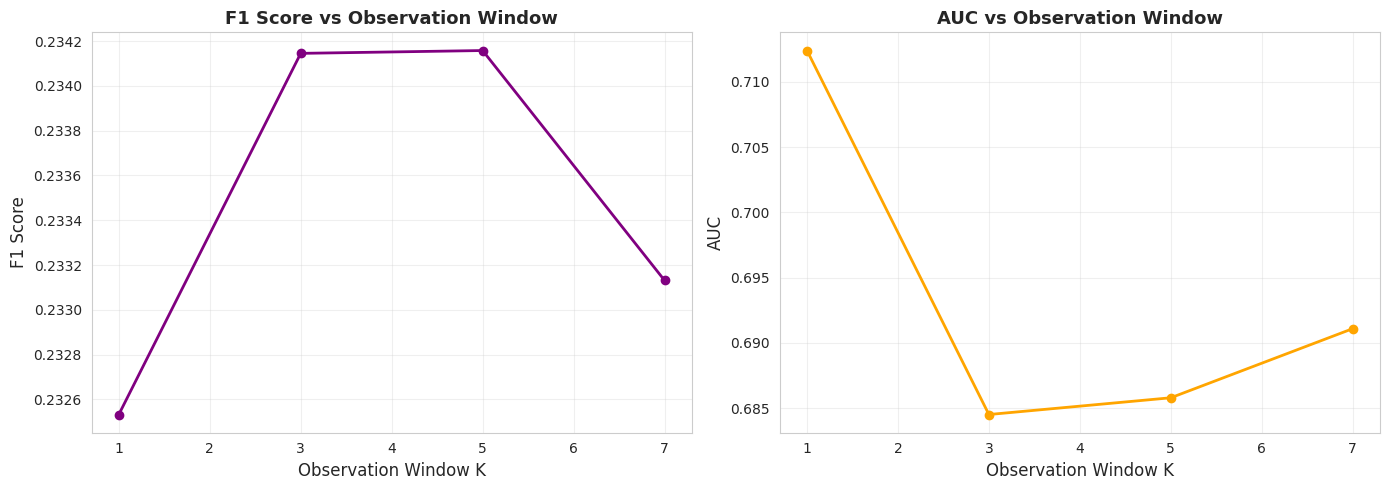

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F1 Score
ax = axes[0]
f1_scores = [results[K]['test']['f1'] for K in CONFIG['observation_windows']]
ax.plot(CONFIG['observation_windows'], f1_scores, marker='o', linewidth=2, color='purple')
ax.set_xlabel('Observation Window K', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('F1 Score vs Observation Window', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# AUC
ax = axes[1]
auc_scores = [results[K]['test']['auc'] for K in CONFIG['observation_windows']]
ax.plot(CONFIG['observation_windows'], auc_scores, marker='o', linewidth=2, color='orange')
ax.set_xlabel('Observation Window K', fontsize=12)
ax.set_ylabel('AUC', fontsize=12)
ax.set_title('AUC vs Observation Window', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Save Results

In [15]:
from pathlib import Path

# Create results directory
RESULTS_DIR = Path('../../results/graph_features_baseline')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Save all metrics
all_metrics = []
for K in CONFIG['observation_windows']:
    for split_name in ['train', 'val', 'test']:
        metrics = results[K][split_name]
        all_metrics.append({
            'K': K,
            'split': split_name,
            'accuracy': metrics['accuracy'],
            'precision': metrics['precision'],
            'recall': metrics['recall'],
            'f1': metrics['f1'],
            'auc': metrics['auc']
        })

metrics_df = pd.DataFrame(all_metrics)
metrics_df.to_csv(RESULTS_DIR / 'all_metrics.csv', index=False)
print(f"Saved metrics to {RESULTS_DIR / 'all_metrics.csv'}")

# Save summary statistics (with std=0 for compatibility with multi-seed notebooks)
summary_stats = []
test_metrics = metrics_df[metrics_df['split'] == 'test']
for K in CONFIG['observation_windows']:
    k_metrics = test_metrics[test_metrics['K'] == K].iloc[0]
    summary_stats.append({
        'K': K,
        'f1_mean': k_metrics['f1'],
        'f1_std': 0.0,
        'auc_mean': k_metrics['auc'],
        'auc_std': 0.0,
        'precision_mean': k_metrics['precision'],
        'precision_std': 0.0,
        'recall_mean': k_metrics['recall'],
        'recall_std': 0.0,
        'accuracy_mean': k_metrics['accuracy'],
        'accuracy_std': 0.0
    })

summary_df = pd.DataFrame(summary_stats)
summary_df.to_csv(RESULTS_DIR / 'summary_statistics.csv', index=False)
print(f"Saved summary to {RESULTS_DIR / 'summary_statistics.csv'}")
print(f"\n✅ All results saved to: {RESULTS_DIR}")

Saved metrics to ../../results/graph_features_baseline/all_metrics.csv
Saved summary to ../../results/graph_features_baseline/summary_statistics.csv

✅ All results saved to: ../../results/graph_features_baseline
